## Recompose example netCDF from scratch 

***Use the example from Stefan?***

To get the data of auxiliary coordinate variables, do the same as above, e.g. `ds['time_bnds'].data`. But imagine we have the coordinate data and wanna newly generate coordinates for boundary variables, we can generate it from the coordinates

### Example from Stefan

In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
import pandas as pd
import xarray as xr

In [ ]:
inpath = "/Users/icdc/Documents/NFDI/Kemeng/publishable_netcdf/data"
file = os.path.join(inpath, "raw", "ESA-SICCI2_ICDC__SeaIceVolumeTimeseries__north_ao_v2.0_fv0.02.txt")
file

In [ ]:
# Read ASCII Data
df = pd.read_csv(file, sep=";", comment="#", header=0, skiprows=6,
                 names=['date', 'sea_ice_volume_km3', 'sea_ice_volume_error_km3'])
df = df.set_index('date')

In [ ]:
df.tail()

In [ ]:
# Convert the data to xarray
dssiv = df.to_xarray()
dssiv

In [ ]:
# Create a continuous time dimension beginning at 2000-01-1 using an average number of days per year that includes a leap year
dssiv['date'] = 365.25 * ((np.round(dssiv['date']*0.01) + (dssiv['date']*0.01 - np.round(dssiv['date']*0.01))/0.12) - 2002.) + 2.0*365.25
dssiv.date

In [ ]:
# How does the time series look like?
plt.figure(figsize=(10,5))
ax = dssiv['sea_ice_volume_km3'].plot(color='k')
ax = plt.xlabel("Date [days since 2000-01-01]", color = 'k')
ax = plt.ylabel('Monthly mean Arctic sea ice volume [km3]', color = 'k')
plt.show()

In [ ]:
# Get DataArray of sea ice volume in km^3
siv = dssiv.sea_ice_volume_km3.data
# Convert the sea ice volume to m^3 (SI units)
siv = siv * 1e6
#print(siv)

siv_error = dssiv.sea_ice_volume_error_km3.data
siv_error = siv_error * 1e6

date = dssiv.date.data

In [ ]:
# Make a new Xarray Dataset
dsout = xr.Dataset(
    data_vars = {
        'sea_ice_volume': (['time'], siv),
        'sea_ice_volume_error': (['time'], siv_error)
    },
    coords = {'time': (['time'], date)}
)
dsout

In [ ]:
# Add Variable Attributes
dsout['time'].attrs = {'standard_name':'time', 
                    'long_name':'date',
                    'units':'days since 2000-01-01',
                    'comment':'date denotes the first day of the respective month'}
dsout['sea_ice_volume'].attrs = {'standard_name':'sea_ice_volume',
                                 'long_name':'monthly_mean_sea_ice_volume',
                                 'units':'m3',
                                 'cell_methods':'time: mean'}
dsout['sea_ice_volume_error'].attrs = {'standard_name':'sea_ice_volume standard_error',
                                       'long_name': 'standard error of monthly_mean_sea_ice_volume',
                                       'units': 'm3',
                                       'cell_methods': 'time: mean'}

In [ ]:
dsout.attrs = {
    'title': 'Winter monthly mean Arctic sea ice volume (October - April)',
    'description': 'Winter monthly mean sea ice volume in the Arctic computed from sea ice thickness derived from satellite radar altimeter observations and sea ice area derived from satellite microwave radiometer observations. For a description of the methods see the pdf-document listed under references.',
    'satellite': 'Envisat, Crysosat-2',

    # These four following entries denote the geographic extent of the source grid (in degree)
    'geospatial_lat_min': 60., 
    'geospatial_lat_max': 90.,
    'geospatial_lon_min': -180.,
    'geospaital_lon_max': 180.,

    # Sea ice volume is a surface parameter; its height and/or altitude is therefore zero (in meter)
    'geospatial_vertical_min': 0.,
    'geospatial_vertical_max': 0.,

    'time_coverage_start': '2002-10-01Z00:00:00Z', # the beginning of the first day of the first month in the data set
    'time_coverage_end': '2017-04-30Z23:59:59Z', # the end of the last day of the last month in the data set
    'time_coverage_duration': 'P105M', # the total number of time steps within this file, here: all months = 105
    'time_coverage_resolution': 'P1M', # the temporal sampling, here: monthly values
    'project': 'ESA-CCI',
    'product_version': 'v2.0',
    'source': 'AMSR-E and AMSR2 sea ice concentration data: http://dx.doi.org/10.5285/5f75fcb0c58740d99b07953797bc041e, SSMIS sea ice concentration data: http://dx.doi.org/10.15770/EUM_SAF_OSI_0008, Envisat-RA2 sea ice thickness data: http://catalogue.ceda.ac.uk/uuid/b1f1ac03077b4aa784c5a413a2210bf5, Cryosat-2 SIRAL sea ice thickness data: http://catalogue.ceda.ac.uk/uuid/48fc3d1e8ada405c8486ada522dae9e8.',
    'contact': '',
    'institution': '',
    'creator_url': 'https://www.cen.uni-hamburg.de/icdc',
    'references': 'https://www.cen.uni-hamburg.de/en/icdc/research/projects/esa-cci-sea-ice-ecv.html, https://www.cen.uni-hamburg.de/en/icdc/data/cryosphere/docs-cryo/sicci-phase2-siv-retrieval-report-v02.pdf',
    'license': 'CC-BY-4.0'
}

In [ ]:
dsout

In [ ]:
dsout.to_netcdf(os.path.join(inpath, "processed", "ESA-SICCI2_ICDC__SeaIceVolumeTimeseries__north_ao_v2.0_fv0.02.nc"))

### Deprecated?

In [ ]:
import numpy as np
import xarray as xr
from cftime import date2num, num2date

In [ ]:
time_units = 'days since 2001-01-01 00:00'
time_vals = date2num(arr_time, time_units)
time_vals

array([ 15,  45,  75, 105, 135, 165, 195, 225, 255, 285, 315, 345, 375,
       405, 435, 465, 495, 525, 555, 585, 615, 645, 675, 705])

In [ ]:
# Boundary Variables (auxiliary coordinates)
arr_time_bnd = np.column_stack((arr_time - 15, arr_time + 15))
arr_lat_bnd = np.column_stack((arr_lat - 0.5, arr_lat + 0.5))
arr_lon_bnd = np.column_stack((arr_lon - 1, arr_lon + 1))

TypeError: unsupported operand type(s) for -: 'cftime._cftime.Datetime360Day' and 'int'

In [ ]:
ds = xr.Dataset(
    coords = {
        'time': (['time'], np.float32(time_vals), {'units':time_units}),
        'latitude': (['lat'], np.float32(arr_lat), {'units':'degrees_north'}),
        'longitude': (['lon'], np.float32(arr_lon), {'units':'degrees_east'})
    },
    data_vars= {'tos': (['time', 'lat', 'lon'],
                        arr_tos,
                        {'units': 'Kelvin'})}
)

ds

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 24, lat: 170, lon: 180)
Coordinates:
  * time       (time) float32 96B 15.0 45.0 75.0 105.0 ... 645.0 675.0 705.0
    latitude   (lat) float32 680B -79.5 -78.5 -77.5 -76.5 ... 87.5 88.5 89.5
    longitude  (lon) float32 720B 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: lat, lon
Data variables:
    tos        (time, lat, lon) float32 3MB 1e+20 1e+20 1e+20 ... 271.5 271.5

We learned about standard netCDF structure of grid data, now we'll move on to learn to make CF conforming netCDF of DSG data. And we will need the skills of using xarray that we learnt from this chapter.

## Covert Binary Data to netCDF

DWD Usecase

Adapted from https://gist.github.com/kmuehlbauer/83f5014a43e88dc467d3236b8da1d1c3

In [22]:
import os
from glob import glob
import wget
import numpy as np
import xarray as xr
import wradlib as wrl
import matplotlib.pyplot as plt

In [11]:
# Set Working Directory
os.chdir('/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan')
os.getcwd()

'/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan'

In [5]:
# URL of the source data
url = "https://opendata.dwd.de/weather/radar/radolan/sf/raa01-sf_10000-2406042350-dwd---bin.bz2"

# Download source data 
filename = wget.download(url, out=os.path.join(os.getcwd()))

In [13]:
# After unzipping...
fpath = glob(os.path.join(os.getcwd(), "*bin"))
fpath

['/Users/icdc/Documents/NFDI/Kemeng/cfbook/src/data/radolan/raa01-sf_10000-2406042350-dwd---bin']

In [15]:
# Inspect RADOLAN xarray Dataset
ds = xr.open_dataset(fpath[0], engine='radolan')
ds

TRIG


/Users/icdc/Documents/NFDI/Kemeng/myenv/venvNetcdf/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'SF' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset> Size: 3MB
Dimensions:  (y: 900, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-06-04T23:50:00
  * y        (y) float64 7kB -4.658e+03 -4.657e+03 ... -3.76e+03 -3.759e+03
  * x        (x) float64 7kB -523.0 -522.0 -521.0 -520.0 ... 374.0 375.0 376.0
Data variables:
    SF       (y, x) float32 3MB ...
Attributes:
    radarid:         10000
    formatversion:   3
    radolanversion:  2.29.1
    radarlocations:  ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld',...
    radardays:       ['asb 24', 'boo 24', 'drs 24', 'eis 24', 'ess 24', 'fbg ...

In [21]:
# Create RADOLAN grid in wgs84 and assign
radolan_grid = wrl.georef.get_radolan_grid(nrows = ds.sizes['y'], 
                                           ncols = ds.sizes['x'],
                                           wgs84 = True,
                                           mode = "radolan")
#radolan_grid

dsg = ds.assign_coords({"lon": (["y", "x"], radolan_grid[..., 0]),
                        "lat": (["y", "x"], radolan_grid[..., 1])})
dsg.info()

xarray.Dataset {
dimensions:
	y = 900 ;
	x = 900 ;
	time = 1 ;

variables:
	float32 SF(y, x) ;
		SF:valid_min = 0 ;
		SF:valid_max = 4095 ;
		SF:standard_name = rainfall_amount ;
		SF:long_name = SF ;
		SF:unit = mm ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;

// global attributes:
	:radarid = 10000 ;
	:formatversion = 3 ;
	:radolanversion = 2.29.1 ;
	:radarlocations = ['asb', 'boo', 'ros', 'hnr', 'umd', 'pro', 'ess', 'fld', 'drs', 'neu', 'nhb', 'oft', 'eis', 'tur', 'isn', 'fbg', 'mem'] ;
	:radardays = ['asb 24', 'boo 24', 'drs 24', 'eis 24', 'ess 24', 'fbg 24', 'fld 24', 'hnr 24', 'isn 24', 'mem 24', 'neu 24', 'nhb 24', 'oft 24', 'pro 24', 'ros 24', 'tur 24', 'umd 24'] ;
}

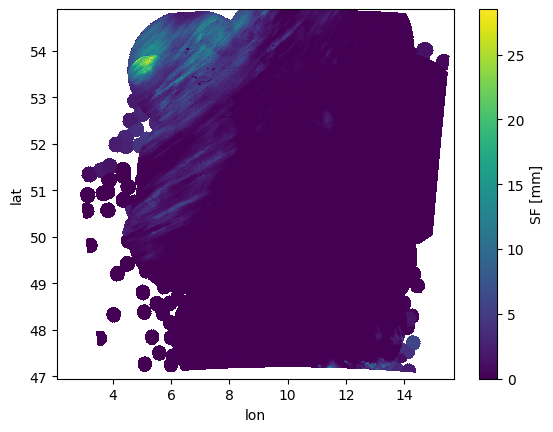

In [24]:
# Simple plot in lat-lon-space
dsg.SF.plot(x = "lon", y = "lat")

In [ ]:
# To make it CF conforming....

In [26]:
# RADKLIM DATASET
fpath2 = '/Users/icdc/Documents/NFDI/Kemeng/publishable_netcdf/data/raw/RW2017.002_200101/raa01-rw2017.002_10000-0101010050-dwd---bin'
ds_radklim = xr.open_dataset(fpath2, engine='radolan')
ds_radklim

TRIG


/Users/icdc/Documents/NFDI/Kemeng/myenv/venvNetcdf/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'RW' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset> Size: 4MB
Dimensions:  (y: 1100, x: 900, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 8B 2001-01-01T00:50:00
  * y        (y) float64 9kB -4.758e+03 -4.757e+03 ... -3.66e+03 -3.659e+03
  * x        (x) float64 7kB -443.0 -442.0 -441.0 -440.0 ... 454.0 455.0 456.0
Data variables:
    RW       (y, x) float32 4MB ...
Attributes:
    radarid:            10000
    formatversion:      3
    radolanversion:     2.18.3
    radarlocations:     ['ham', 'ros', 'emd', 'han', 'umd', 'bln', 'ess', 'fl...
    moduleflag:         1
    reanalysisversion:  2017.002
    intervalunit:       0

In [27]:
radklim_grid = wrl.georef.get_radolan_grid(nrows = ds_radklim.sizes["y"],
                                           ncols = ds_radklim.sizes["x"],
                                           wgs84 = True,
                                           mode = "radolan")
dsg_radklim = ds_radklim.assign_coords({"lon": (["y", "x"], radklim_grid[..., 0]),
                                        "lat": (["y", "x"], radklim_grid[..., 1])})
dsg_radklim.info()

xarray.Dataset {
dimensions:
	y = 1100 ;
	x = 900 ;
	time = 1 ;

variables:
	float32 RW(y, x) ;
		RW:valid_min = 0 ;
		RW:valid_max = 4095 ;
		RW:standard_name = rainfall_rate ;
		RW:long_name = RW ;
		RW:unit = mm h-1 ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	float64 lon(y, x) ;
	float64 lat(y, x) ;

// global attributes:
	:radarid = 10000 ;
	:formatversion = 3 ;
	:radolanversion = 2.18.3 ;
	:radarlocations = ['ham', 'ros', 'emd', 'han', 'umd', 'bln', 'ess', 'fld', 'drs', 'neu', 'nhb', 'fra', 'eis', 'tur', 'muc', 'fbg'] ;
	:moduleflag = 1 ;
	:reanalysisversion = 2017.002 ;
	:intervalunit = 0 ;
}

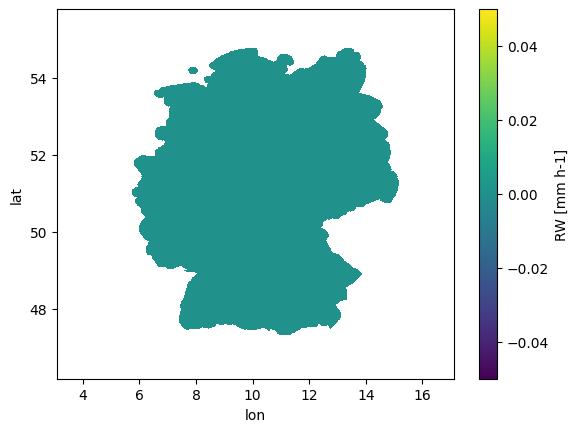

In [28]:
dsg_radklim.RW.plot(x = "lon", y = "lat")